In [18]:
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt

In [57]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


<Axes: title={'center': "Wikipedia pageviews for 'Peyton Manning'"}, xlabel='ds'>

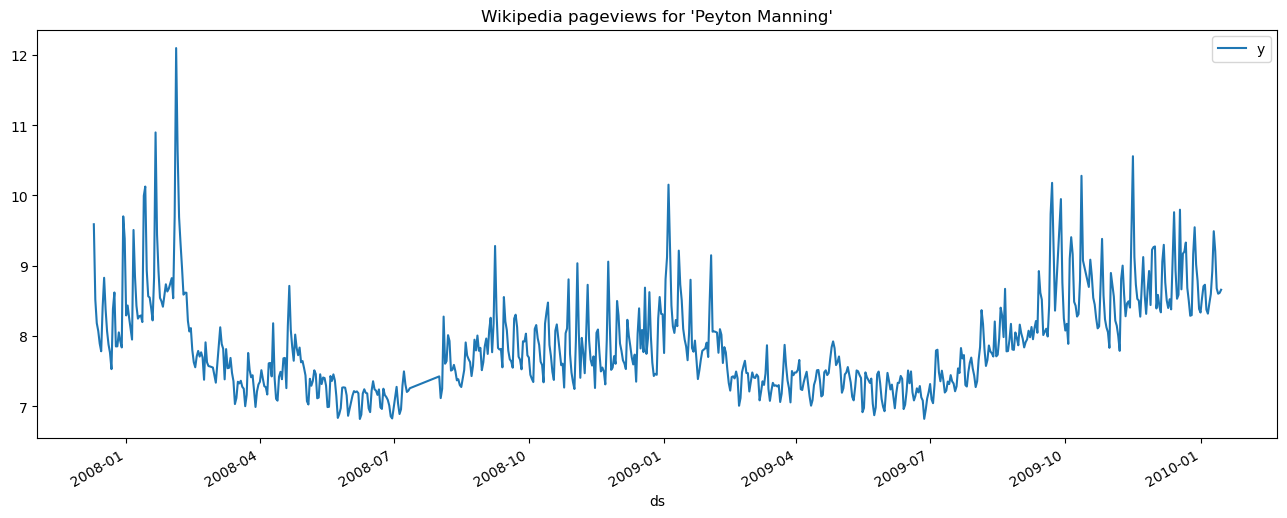

In [58]:
df = df[:730]
# Make sure we work with datetime types
df["ds"] = pd.to_datetime(df["ds"])
# Scale the data
y_max = df["y"].max()
df["y_scaled"] = df["y"] / y_max
df["t"] = (df["ds"] - df["ds"].min()) / (df["ds"].max() - df["ds"].min())
df.plot(x='ds', y='y', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning'")

In [59]:
def trend_model(model, t, n_changepoints=25, changepoints_prior_scale=None, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC.
    :param model: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with model:
        # initial growth
        k = pm.Normal("k", 0 , growth_prior_scale)

        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential("tau", 1.5)
    
        # rate of change
        delta = pm.Laplace("delta", 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal("m", 0, 5)
        gamma = -s * delta
        trend = pm.Deterministic("trend", (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma)))
        
    return trend, A, s

model = pm.Model()
with model:
    trend, A, s = trend_model(model, np.array(df["t"]))
    sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
    pm.Normal("obs", mu=trend, sigma=sigma, observed=df["y_scaled"])

Sampling: [delta, k, m, obs, sigma, tau]


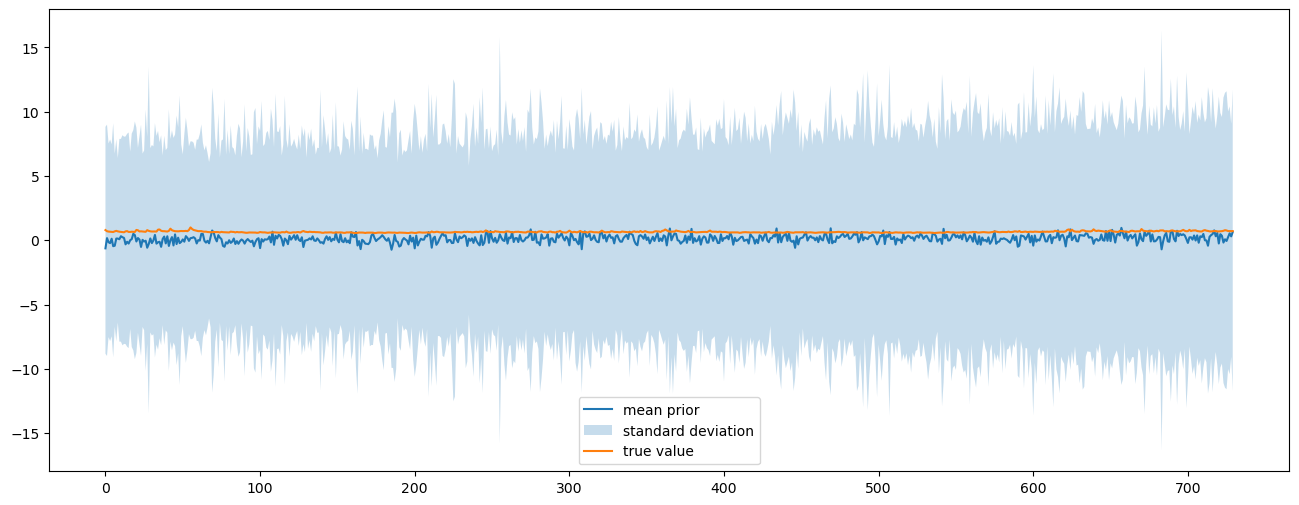

In [60]:
def sanity_check(model, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=model, var_names=["obs"], return_inferencedata=False)["obs"]
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label="mean prior")
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label="standard deviation")
    plt.plot(df["y_scaled"], label="true value")
    plt.legend()

# And run the sanity check
sanity_check(model, df)

Output()

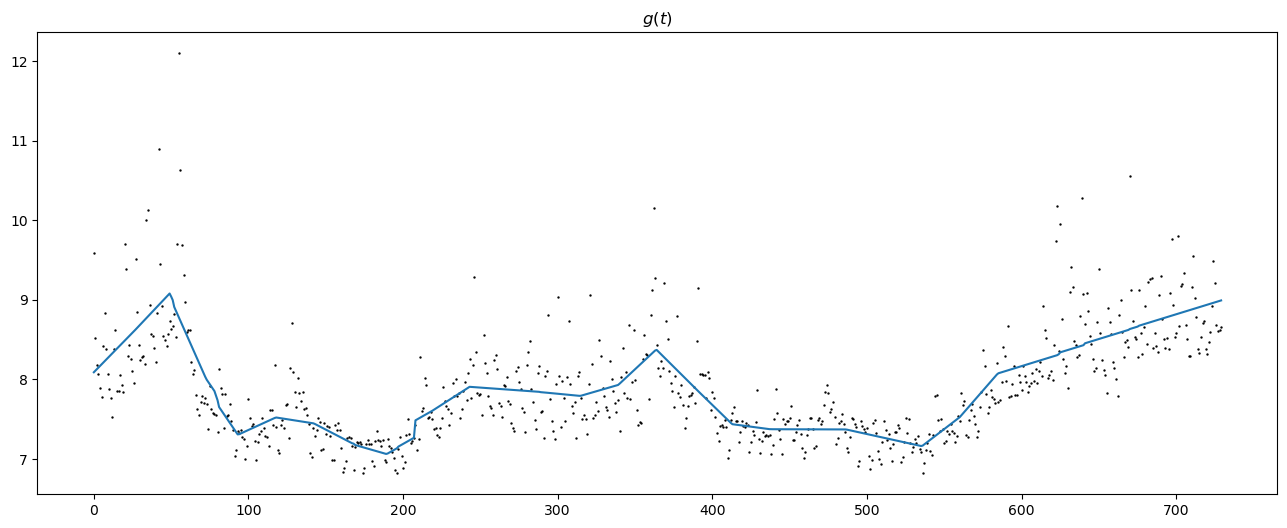

In [61]:
# Find a point estimate of the models parameters
with model:
    aprox = pm.find_MAP()

# rescale to original scale
g = aprox["trend"] * df["y"].max()

plt.figure(figsize=(16, 6))
plt.title("$g(t)$")
plt.plot(g)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color="black")

In [51]:
with model:
    linear_trace = pm.sample(50, return_inferencedata=True, chains=1)
    linear_prior = pm.sample_posterior_predictive(trace=linear_trace)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["ds"],
    az.extract_dataset(linear_prior, group="posterior_predictive", num_samples=100)["obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["ds"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [k, delta, m, sigma]


Output()

ValueError: Not enough samples to build a trace.

In [62]:
def fourier_series(t, p=365.25, n=10):
    x = 2 * np.pi * np.arange(1, n + 1) / p
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

def seasonality_model(model, df, period="yearly", seasonality_prior_scale=10):
    if period == "yearly":
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df["ds"].max() - df["ds"].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df["ds"].max() - df["ds"].min()).days
        
    x = fourier_series(np.array(df["t"]), p, n)
    
    with model:
        beta = pm.Normal(f"beta_{period}", mu=0, sigma=seasonality_prior_scale, shape=2 * n)
        
    return x, beta

model = pm.Model()
with model:
    trend, A, s = trend_model(model, np.array(df["t"]))

    x_yearly, beta_yearly = seasonality_model(model, df, "yearly")
    x_weekly, beta_weekly = seasonality_model(model, df, "weekly")

    trend += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
    sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
    obs = pm.Normal("obs", mu=trend, sigma=sigma, observed=df["y_scaled"])

In [89]:
with model:
    linear_seasonality_trace = pm.sample(500, chains=4, cores=4, return_inferencedata=True)
    linear_seasonality_posterior = pm.sample_posterior_predictive(trace=linear_seasonality_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, tau, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 844 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'beta_yearly'}>,
        <Axes: title={'center': 'beta_yearly'}>],
       [<Axes: title={'center': 'beta_weekly'}>,
        <Axes: title={'center': 'beta_weekly'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'trend'}>,
        <Axes: title={'center': 'trend'}>]], dtype=object)

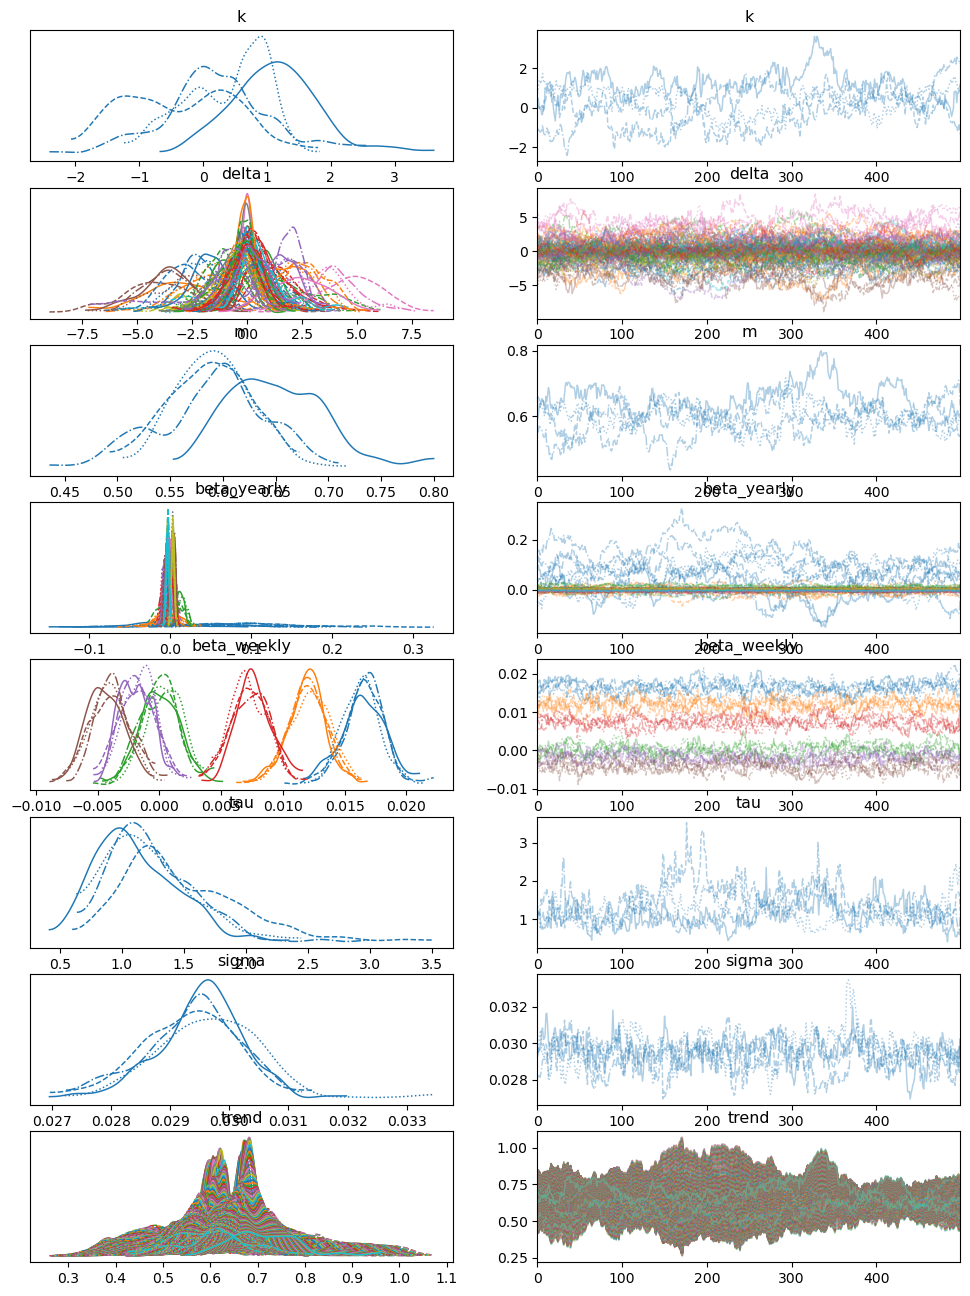

In [90]:
pm.plot_trace(linear_seasonality_trace)

/tmp/ipykernel_148375/772986554.py:38: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


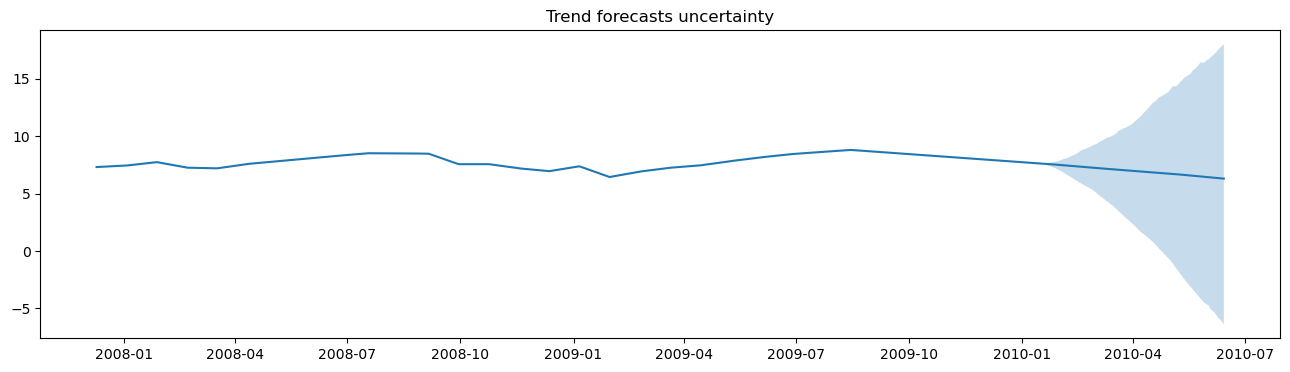

In [91]:
n_samples = 1000
days = 150
history_points = df.shape[0]
probability_changepoint = 25 / history_points

future = pd.DataFrame({"ds": pd.date_range(df["ds"].min(), 
                                           df["ds"].max() + pd.Timedelta(days, "D"), 
                        df.shape[0] + days)})
future['t'] = (future["ds"] - df["ds"].min()) / (df["ds"].max() - df["ds"].min())

# vector distributions
beta_yearly = linear_seasonality_trace["posterior"]["beta_yearly"].mean(["chain", "draw"])
beta_weekly = linear_seasonality_trace["posterior"]["beta_weekly"].mean(["chain", "draw"])
delta = linear_seasonality_trace["posterior"]["delta"].mean(["chain", "draw"])

# scalar distributions
k = linear_seasonality_trace["posterior"]["k"].mean().to_numpy()
m = linear_seasonality_trace["posterior"]["m"].mean().to_numpy()

trend_forecast = []
lambda_ = linear_seasonality_trace["posterior"]["tau"].mean()

future_t = np.array(future["t"])

for n in range(n_samples):
    new_changepoints = future["t"][future["t"] > 1].values
    sample = np.random.random(new_changepoints.shape)
    new_changepoints = new_changepoints[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (future_t[:, None] > new_s) * 1

    trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['y'].max())
    
trend_forecast = np.array(trend_forecast)

date = future["ds"].dt.to_pydatetime()
plt.figure(figsize=(16, 4))
plt.title("Trend forecasts uncertainty")
plt.plot(date, trend_forecast.mean(0))
quant = np.quantile(trend_forecast, [0.025, 0.975], axis=0)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

In [ ]:
with m:
    # Make predictions conditioned on new Xs
    pm.set_data({"x": [-1, 3, 5]})
    pp = pm.sample_posterior_predictive(idata, predictions=True, random_seed=rng)

/tmp/ipykernel_134558/2515349285.py:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_posterior, group="posterior_predictive", num_samples=100)[
/tmp/ipykernel_134558/2515349285.py:15: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
/tmp/ipykernel_134558/2515349285.py:23: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(linear_seasonality_trace, group="posterior", num_samples=100)["beta_yearly"][


Text(0, 0.5, 'Percent change')

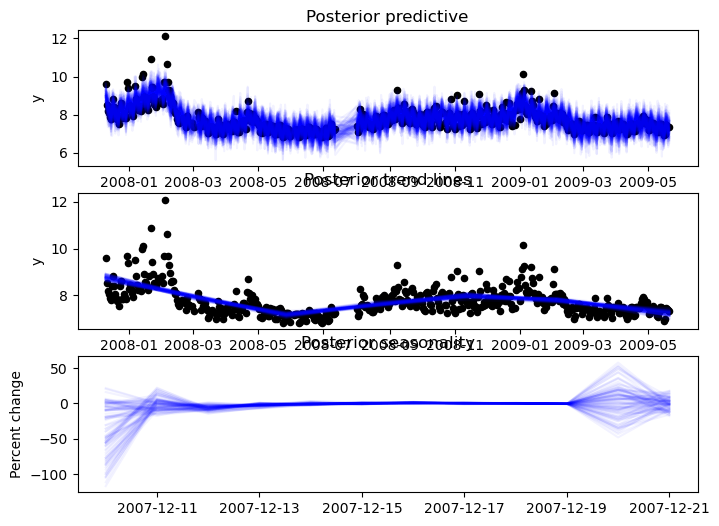

In [79]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, figsize=(8, 6))
ax[0].plot(
    df["ds"],
    az.extract_dataset(linear_seasonality_posterior, group="posterior_predictive", num_samples=100)[
        "obs"
    ]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
ax[1].plot(
    df["ds"],
    az.extract_dataset(linear_trace, group="posterior", num_samples=100)["trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="ds", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines")
ax[2].plot(
    df["ds"].iloc[:12],
    az.extract_dataset(linear_seasonality_trace, group="posterior", num_samples=100)["beta_yearly"][
        :12
    ]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Posterior seasonality")
ax[2].set_ylabel("Percent change")
# formatter = mdates.DateFormatter("%b")
# ax[2].xaxis.set_major_formatter(formatter);